## *Statistics coded:* Living conditions in Europe - poverty and social exclusion

Prepared by [**Lasai Barreñada**](https://github.com/LasaiBarrenada) (EMOS).

This notebook aims at illustrating the *Statistics Expplained* article on [Living conditions in Europe - poverty and social exclusion](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_poverty_and_social_exclusion).


### Settings

The libraries needed for this notebook are the following ones:

In [56]:
import numpy as np
from eurostatapiclient import EurostatAPIClient
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


### Documentation:
- [**Numpy**](https://numpy.org/)
- [**EurostatApiClient**](https://pypi.org/project/eurostatapiclient/)
- [**Matplotlib**](https://matplotlib.org/contents.html)
- [**Seaborn**](https://seaborn.pydata.org/)

#### Set up eurostatapiclinet by supplying settings, which will stay the same throught

In [57]:
#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [58]:
def setvaluegraph (value #list of the values 
                   ,axis #Axis where we represent the value
                   , horizontal #True if the graph is horizontal and False if it's vertical 
                   ,xpos = 0 # Parameter to adjust the position of the value on x axis
                   ,ypos= 0 # Parameter to adjust the position of the value on y axis
                   , fontsize= 8
                   , color = 'b'
                   , weight = 'normal'
                   , style = 'normal'
                   , form = '{}'): #Format of the desired value e.g {:.1f}% for pcg
    if horizontal:
         for i,v in enumerate(value):
             axis.text(v-xpos,i-ypos,str(form.format(v)), fontsize = fontsize, color = color, weight = weight, style = style)
    else:
        for i,v in enumerate(value):
            axis.text(i-xpos,v-ypos,str(form.format(v)), fontsize = fontsize, color = color, weight = weight, style = style)
# This function allows to set the value of the represented graph

### Poverty and social exclusion

#### Figure 1

Text(0.3, 1, 'People at risk of porverty or social exclusion in EU, 2008-2018 \n (in million persons and % of total population, 2020 data)')

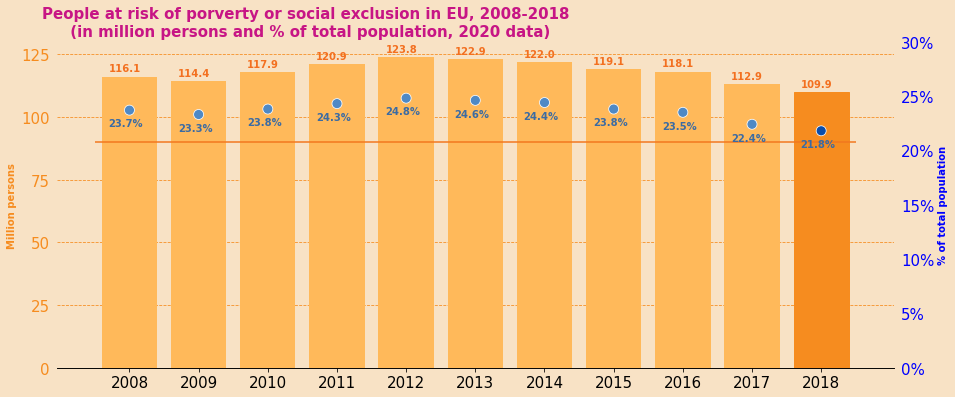

In [59]:
#We define params of dataframes
params_df1 = {
    'AGE': 'TOTAL',
    'sinceTimePeriod': '2008',
    'sex': 'T',
    'geo':'EU',
    'unit':'THS_PER'
} 
params_df2 = {
    'AGE': 'TOTAL',
    'sinceTimePeriod': '2008',
    'sex': 'T',
    'geo':'EU',
    'unit':'PC'
} 
# We retrieve the info with the EurostatApiClient
dataframe_1 = client.get_dataset('ilc_peps01', params=params_df1).to_dataframe()
dataframe_2 = client.get_dataset('ilc_peps01', params=params_df2).to_dataframe()
params_df1.update({'lastTimePeriod': '2018'})
dataframe_1 = dataframe_1[dataframe_1.time <= params_df1['lastTimePeriod']]
params_df2.update({'lastTimePeriod': '2018'})
dataframe_2 = dataframe_2[dataframe_2.time <= params_df2['lastTimePeriod']]
dataframe_1 = dataframe_1.pivot(index='time', columns='age', values='values').reset_index()
dataframe_2 = dataframe_2.pivot(index='time', columns='age', values='values').reset_index()

values = dataframe_1['TOTAL']

fig = plt.figure(facecolor='#f8e2c5', figsize = (15,6)) #We create the figure
ax=fig.add_subplot(facecolor='#f8e2c5')

barplot =ax.bar(dataframe_1['time'],dataframe_1['TOTAL']/1000, color=('#ffb95a')) #We draw the barplot with the first dataframe
barplot[10].set_color('#f68c1f') #Highlight the 10th bar

axes1 = plt.gca() 
axes2 = axes1.twinx() #We create the secondary axis with twinx
scatterplot= sns.scatterplot(x=dataframe_2['time'], #We draw the scatterplot and specify the arguments
                             y = dataframe_2['TOTAL'],
                             hue= dataframe_2['time'],
                             ax=axes2 ,
                             s = 100 ,
                             palette=['#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#0b4dab'],
                             legend = False)
# We set the ticks of both axis
axes2.set_yticks(range(0,31,5))
axes1.set_yticks(range(0,151,25))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks =  mtick.FormatStrFormatter(fmt)
axes2.yaxis.set_major_formatter(yticks) #We set the ticks of the right axis in percentage
ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left = False, right=False, colors = '#f68c1f' , labelsize = 15)
ax.tick_params(axis ='x', which = 'both', labelsize = 15)
axes2.tick_params(axis='y',right=False, colors = 'b', labelsize = 15)
ax.yaxis.label.set_color('#f68c1f')
ax.set_ylabel('Million persons', weight = 'bold')
axes2.yaxis.label.set_color('b')
axes2.set_ylabel('% of total population' , weight = 'bold')
ax.set_axisbelow(True)

ax.hlines(values[10]/1000-20,-0.5,10.5, colors='#f2771e') #Horizontal line with the last value minus 20 million

#Set the values in the graph with the function defined above
setvaluegraph(round(dataframe_1['TOTAL']/1000,1),ax,False,0.3,-2,10,color='#f37020',weight='bold')
setvaluegraph(dataframe_2['TOTAL'],axes2,False,0.3,1.5,10,color='#3b6ba3',weight = 'bold', form ='{:.1f}%' )

ax.grid(True, which = 'major', axis = 'y' , color ='#f68c1f', linestyle = '--' , zorder = 100)
axes2.spines['right'].set_visible(False)
sns.despine(top=True, right=True, left=True, bottom=False)

ax.set_title('People at risk of porverty or social exclusion in {}, {}-{} \n (in million persons and % of total population, 2020 data)'.format(params_df1['geo'],params_df1['sinceTimePeriod'],params_df1['lastTimePeriod']),
             fontsize=15,fontweight='bold',y=1, x=0.3, c = 'mediumvioletred')


### Poverty and social exclusion
![Figure 1: People at risk of poverty or social exclusion, 2008-2018(EU-28, million persons)](https://ec.europa.eu/eurostat/statistics-explained/images/f/fe/People_at_risk_of_poverty_or_social_exclusion%2C_2008-2018_2.jpeg)

Figure 1: People at risk of poverty or social exclusion, 2008-2018 (EU-28, million persons)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en))



 # **Figure 2**
![Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018](https://ec.europa.eu/eurostat/statistics-explained/images/8/80/People_at_risk_of_poverty_or_social_exclusion_by_socio-economic_characteristic%2C_2018_3.png)

Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018
(% share of the total population)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en))
, ([ilc_peps02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps02&lang=en))
 and ([ilc_peps04](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps04&lang=en))

In [60]:
import numpy as np
from eurostatapiclient import EurostatAPIClient
# Choose service version : only v2.1 is currently available
VERSION = 'v2.1'

# Only json is currently available
FORMAT = 'json'

# Specify language : en, fr, de
LANGUAGE = 'en'

client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)


 # **Figure 3**
![Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018
(% share of the total population)](https://ec.europa.eu/eurostat/statistics-explained/images/2/26/People_at_risk_of_poverty_or_social_exclusion_by_degree_of_urbanisation%2C_2018_2.png)
Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018
(% share of the total population)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en)) and ([ilc_peps13](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps13&lang=en))

# **Figure 4**
![Figure 4: People at risk of poverty or social exclusion by type of risk, EU-28, 2018 (million persons)](https://ec.europa.eu/eurostat/statistics-explained/images/3/3d/People_at_risk_of_poverty_or_social_exclusion_by_type_of_risk%2C_EU-28%2C_2018_3.png)

Figure 4: People at risk of poverty or social exclusion by type of risk, EU-28, 2018 (million persons)

Source: Eurostat ([ilc_pees01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01&lang=en))

# **Figure 5**
![Figure 5: People at risk of poverty or social exclusion by type of risk, 2018(% share of the total population)
](https://ec.europa.eu/eurostat/statistics-explained/images/4/4a/People_at_risk_of_poverty_or_social_exclusion_by_type_of_risk%2C_2018_2.png)
Figure 5: People at risk of poverty or social exclusion by type of risk, 2018(% share of the total population)

Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_pees01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01&lang=en))
# **Figure 6**
![Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 (% / thousand PPS)
](https://ec.europa.eu/eurostat/statistics-explained/images/e/ec/At-risk-of-poverty_rate_and_at-risk-of-poverty_threshold%2C_2018.png)
Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 (% / thousand PPS)

Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li01&lang=en))
# **Figure 7**
![Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018 (% share of total population)](https://ec.europa.eu/eurostat/statistics-explained/images/0/05/At-risk-of-poverty_rate_-_before_and_after_-_deducting_housing_costs%2C_2018.png)
Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018 (% share of total population)
Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li48](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li48&lang=en))
# **Figure 8**
![Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018 (% share of total population)
](https://ec.europa.eu/eurostat/statistics-explained/images/f/fe/At-risk-of-poverty_rate_-_before_and_after_-_social_transfers%2C_2018.png)
Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018 (% share of total population)
Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li10](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li10&lang=en))

# **Map 1**
![Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 (percentage points difference, 2018 minus 2008)
](https://ec.europa.eu/eurostat/statistics-explained/images/7/7a/AROPE_2019_map1-1.png)

Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 (percentage points difference, 2018 minus 2008)

Source: Eurostat ([ilc_li22b](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li22b&lang=en))

### Additional material

At this stage, it is up to you to extend the work presented in the notebook with further analysis/visualisation you deem relevant. 